<a href="https://colab.research.google.com/github/therokitoki/AA2_TP_Alsop-Hachen-Nemeth/blob/main/ejercicio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico AAII

Alumnos: Agustín Alsop, Rocío Hachen, Ulises Nemeth

# Ejercicio 3

## Descripción:
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

## Dataset:
https://drive.google.com/file/d/1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ/view?usp=drive_link

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

> - buildings
> - forest
> - glacier
> - mountain
> - sea
> - street

Las imágenes están divididas en tres conjuntos:
- Train: Alrededor de 14,000 imágenes para entrenamiento.
- Test: Alrededor de 3,000 imágenes para evaluación del modelo.
- Prediction: Alrededor de 7,000 imágenes para predicción final.

## Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.


Los modelos a diseñar son:
- Modelo con capas densas.
- Modelo con capas convolucionales y densas.
- Modelo que incluya bloques residuales identidad.
- Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning).


Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


# Librerias

In [16]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import os

# Para trabajar con Redes Neuronales
import tensorflow as tf
from tensorflow.keras.layers import Input, RandomFlip, RandomContrast, RandomTranslation, Flatten, Dropout, Dense, Conv2D, Activation, MaxPooling2D, Rescaling, GlobalAveragePooling2D, BatchNormalization, Add, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
import seaborn as sns

In [17]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

# Descarga de dataset

In [ ]:
!gdown 1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ

In [ ]:
zip_path = '/content/TP1-3-natural-scenes.zip'
extract_path = 'unzipped_files'

os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Preparación de datos

In [ ]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("/content/unzipped_files/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("/content/unzipped_files/seg_test/seg_test")
TEST_DATA_DIRECTORY = Path("/content/unzipped_files/seg_pred")

# Tamaño del lote (batch size)
BATCH_SIZE = 32

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


Visualizamos los nombres de las clases, y algunas de las imágenes del dataset

# Análisis exploratorio

En este ejercicio estamos trabajando con un dataset que contiene imágenes de distintos lugares. Debajo podemos observar que contiene 6 clases: edificios/construcciones, bosques, glaciares, montañas, mar y calles.

In [40]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Número de clases: {num_classes}")
print(class_names)

Número de clases: 6
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


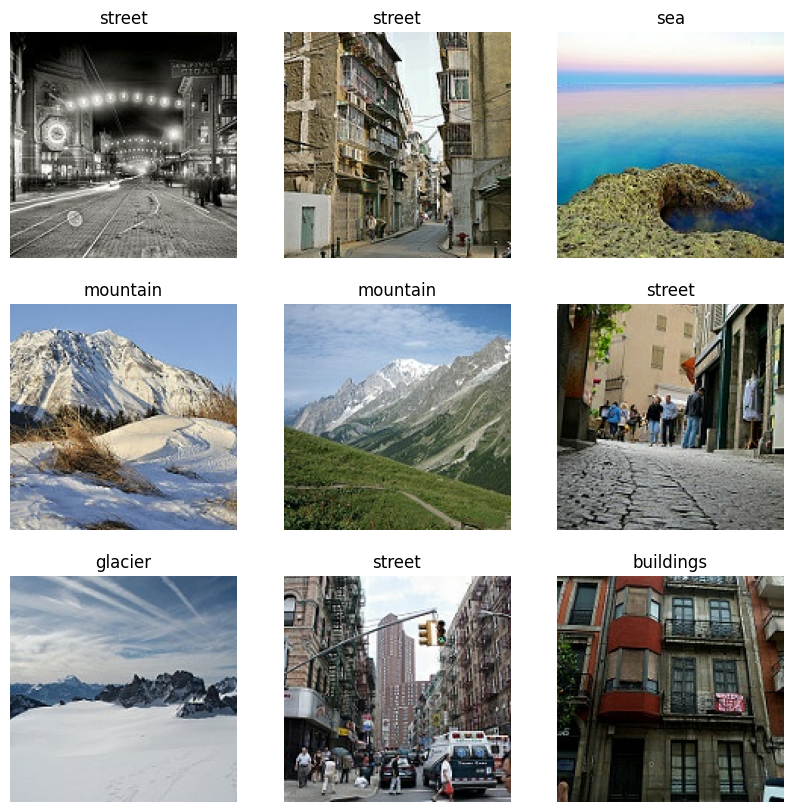

In [41]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

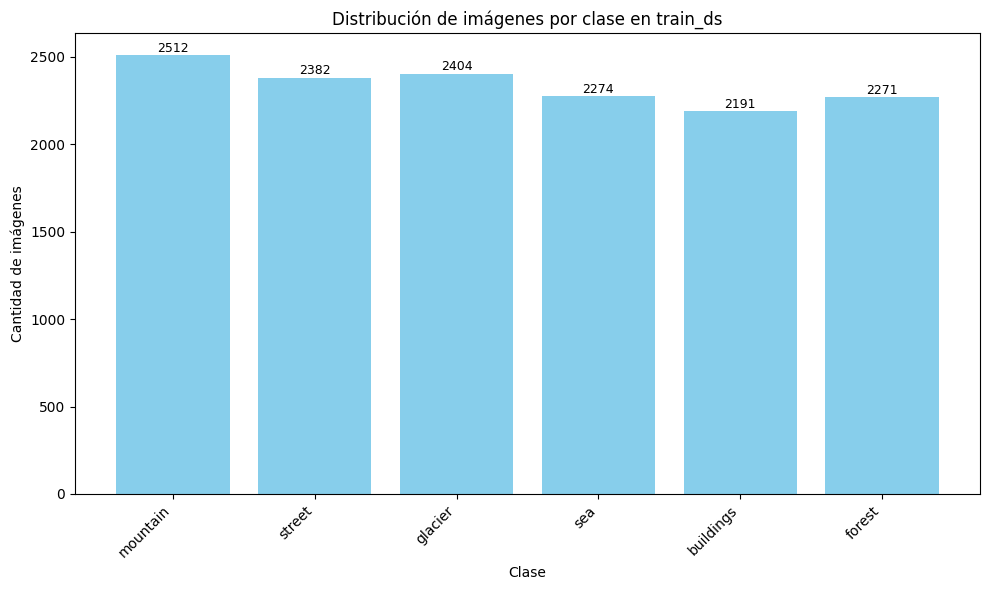

In [42]:
# Contamos cuántas imágenes hay de cada clase
cant_clases = {}
for images, labels in train_ds:
    for label in labels:
        class_idx = np.argmax(label)
        class_name = class_names[class_idx]
        if class_name in cant_clases:
            cant_clases[class_name] += 1
        else:
            cant_clases[class_name] = 1

# Visualizamos
plt.figure(figsize=(10, 6))
bars = plt.bar(cant_clases.keys(), cant_clases.values(), color='skyblue')
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de imágenes por clase en train_ds")
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, str(int(yval)),
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Podemos observar que el dataset se encuentra balanceado, ya que cada clase tiene alrededor de 2300 imagenes

# Modelos

In [ ]:
model_save_path = "/content/models/"

## Modelo con capas densas

In [57]:
checkpoint_acc_dense = ModelCheckpoint(
    model_save_path + "model-dense-{epoch:02d}-acc{val_accuracy:.3f}.keras",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.4,
    mode="max",
)

### Definición del modelo

In [58]:
model_dense = Sequential([
    Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
    ])

### Compilación

In [59]:
# Compilación
model_dense.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [60]:
model_dense.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    34,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,693,382 (132.34 MB)

 Trainable params: 34,693,382 (132.34 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [61]:
EPOCHS= 20

# Entrenamiento
history = model_dense.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc_dense]
    )

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 77s 173ms/step - accuracy: 0.2764 - loss: 7.8063 - val_accuracy: 0.3447 - val_loss: 1.5331
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.3223 - loss: 1.6001 - val_accuracy: 0.4567 - val_loss: 1.4509
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 76s 173ms/step - accuracy: 0.3461 - loss: 1.5530 - val_accuracy: 0.3107 - val_loss: 1.6059
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 77s 174ms/step - accuracy: 0.2789 - loss: 1.6619 - val_accuracy: 0.3990 - val_loss: 1.5734
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 76s 173ms/step - accuracy: 0.3034 - loss: 1.6325 - val_accuracy: 0.3310 - val_loss: 1.5545
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 76s 173ms/step - accuracy: 0.2902 - loss: 1.6359 - val_accuracy: 0.3493 - val_loss: 1.5380
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 76s 174ms/step - accuracy: 0.3018 - loss: 1.6126 - val_accuracy: 0.3620 - val_loss: 1.5579
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 77s 176ms/step - accuracy: 0.3005 - loss: 1

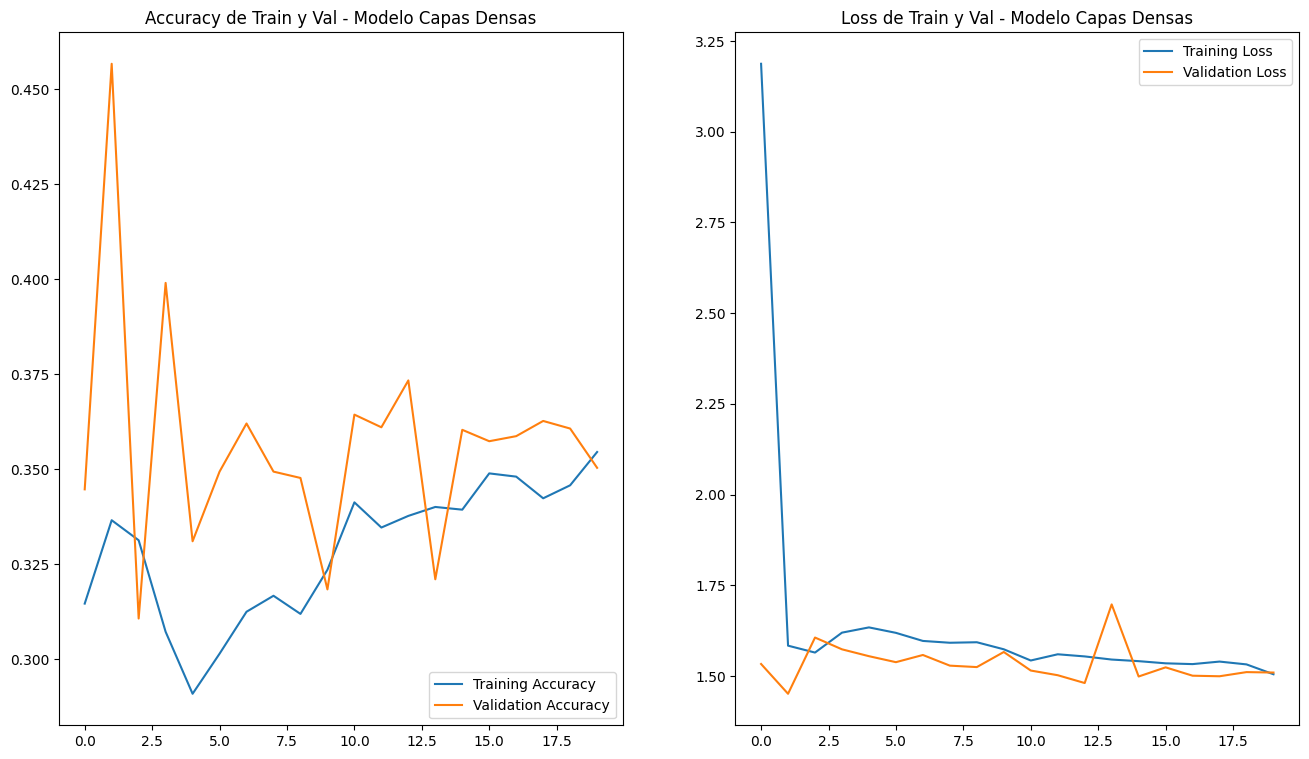

In [62]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy de Train y Val - Modelo Capas Densas')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss de Train y Val - Modelo Capas Densas')
plt.show()

Podemos observar oscilaciones bruscas en la gráfica de Accuracy. Esto se debe a que al no usar capas convolucionales, el modelo está aprendiendo con mayor dificultad, y esto hace que cada epoch varíe drásticamente dependiendo del batch.

### Predicción y matriz de confusión

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


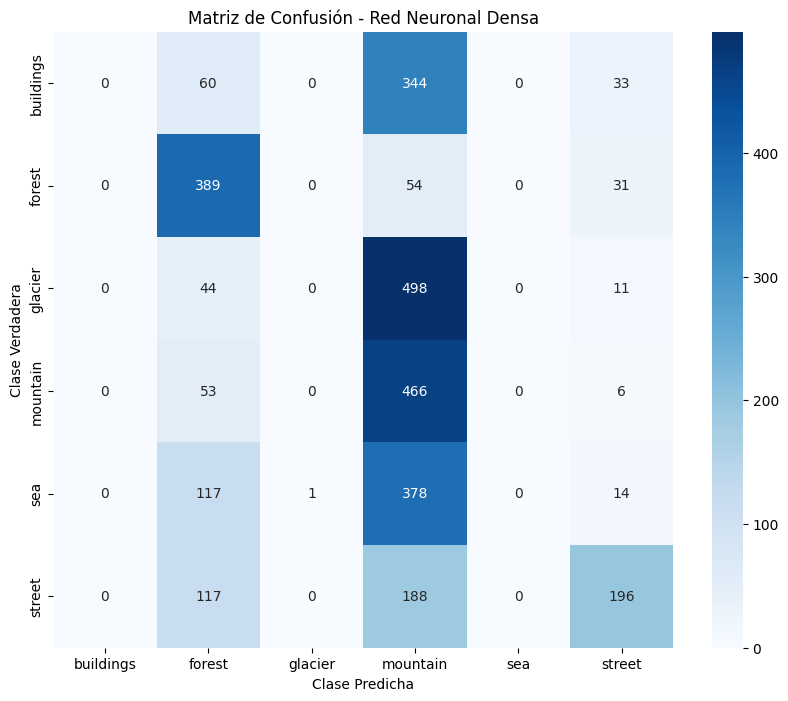


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.50      0.82      0.62       474
     glacier       0.00      0.00      0.00       553
    mountain       0.24      0.89      0.38       525
         sea       0.00      0.00      0.00       510
      street       0.67      0.39      0.49       501

    accuracy                           0.35      3000
   macro avg       0.24      0.35      0.25      3000
weighted avg       0.23      0.35      0.25      3000



c:\Users\rocio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rocio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rocio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [65]:
# Predicciones sobre el conjunto de validación
y_pred_probs = model_dense.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - Red Neuronal Densa')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


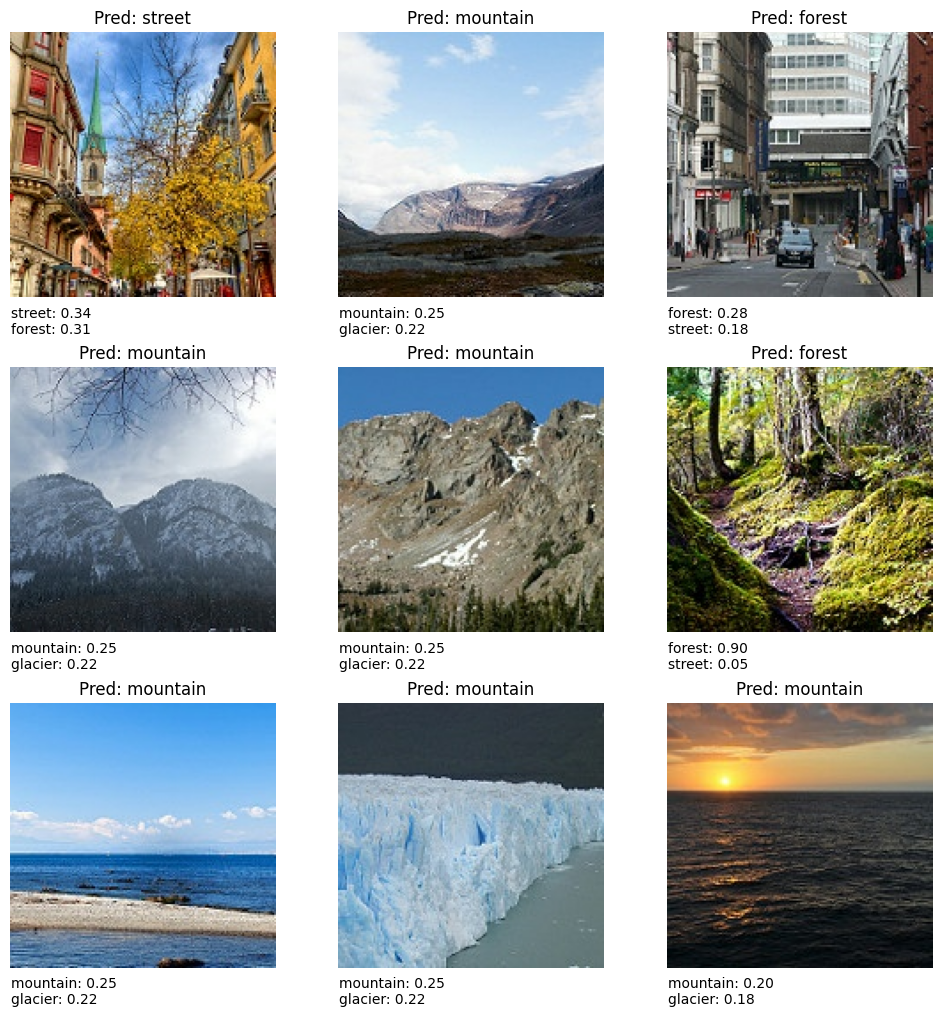

In [63]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción
preds = model_dense.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))
    class_index = predicted_labels[i]
    class_label = class_names[class_index]

    top2_indices = np.argsort(preds[i])[::-1][:2]

    label1 = f"{class_names[top2_indices[0]]}: {preds[i][top2_indices[0]]:.2f}"
    label2 = f"{class_names[top2_indices[1]]}: {preds[i][top2_indices[1]]:.2f}"

    confidence = preds[i][class_index] * 100  # Calculamos dentro del loop
    plt.title(f"Pred: {class_label}", fontsize=12)
    plt.text(0, 170, f"{label1}\n{label2}", fontsize=10, color='black')
    plt.axis("off")
plt.tight_layout()
plt.show()

### Conclusiones

Los modelos que se componen únicamente de capas densas se encuentran ya de por sí limitados al trabajar con datos de imágenes. Esto se debe a que la imagen se aplana al comienzo y se pierden los datos espaciales.

Nuestra primera red de capas densas, que era muy simple `(Flatten → Dense(16, relu) → Dense(6, softmax))` obtenía una Accuracy de apenas `0.18`, lo cual apenas supera al azar (100%/6 = 16.6%).

Intentamos sumar capas ocultas, neuronas y dropouts para evitar el overfitting, lo cual mejoró el Accuracy hasta `0.33`. De todos modos, esto sigue siendo un Accuracy bajo; nuestra conclusión es que un modelo de capas densas no es una solución efectiva para este tipo de problema.

Se podría utilizar este tipo de red como un modelo base, que nos ayude a determinar el rendimiento minimo que deberían tener nuestras redes convolucionales.

## Modelo con capas convolucionales y densas

### Definición del modelo

In [ ]:
# Definición del modelo
model_conv = Sequential([
    Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    RandomTranslation(0.1, 0.1, fill_mode="reflect"),
    RandomContrast(0.2),

    Conv2D(8, (3, 3)),
    Activation("relu"),
    Conv2D(16, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(16, activation="relu"),
    Dense(6, activation="softmax")
])

### Compilación

In [ ]:
# Compilación
model_conv.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model_conv.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_18 (RandomFlip)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_19 (RandomFlip)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_9            │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_9               │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 148, 148, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 148, 148, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 146, 146, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 146, 146, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 71, 71, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 71, 71, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 33, 33, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │       262,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,790 (1.09 MB)

 Trainable params: 286,790 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [ ]:
EPOCHS= 20

# Entrenamiento
hist_conv = model_conv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc]
    )

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.4634 - loss: 1.3039 - val_accuracy: 0.5547 - val_loss: 1.0544
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6183 - loss: 0.9315 - val_accuracy: 0.6900 - val_loss: 0.7829
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6904 - loss: 0.8170 - val_accuracy: 0.7490 - val_loss: 0.6951
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7347 - loss: 0.7156 - val_accuracy: 0.7870 - val_loss: 0.6116
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7480 - loss: 0.6769 - val_accuracy: 0.7757 - val_loss: 0.5983
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7643 - loss: 0.6391 - val_accuracy: 0.7357 - val_loss: 0.6675
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7783 - loss: 0.6116 - val_accuracy: 0.7810 - val_loss: 0.6130
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7805 - loss: 0.6012 - v

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = hist_conv.history['accuracy']
val_acc = hist_conv.history['val_accuracy']

loss = hist_conv.history['loss']
val_loss = hist_conv.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predicción y matriz de confusión

El modelo converge bien y mantiene una brecha pequeña entre el entrenamiento y la validación, lo que indica buena capacidad de generalización. No se observa overfitting.

In [ ]:
# Predicciones sobre el conjunto de validación
y_pred_probs = model_conv.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - ResNet')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

NameError: name 'model_conv' is not defined

In [ ]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción
preds = model_conv.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))
    class_index = predicted_labels[i]
    class_label = class_names[class_index]

    top2_indices = np.argsort(preds[i])[::-1][:2]

    label1 = f"{class_names[top2_indices[0]]}: {preds[i][top2_indices[0]]:.2f}"
    label2 = f"{class_names[top2_indices[1]]}: {preds[i][top2_indices[1]]:.2f}"

    confidence = preds[i][class_index] * 100  # Calculamos dentro del loop
    plt.title(f"Pred: {class_label}", fontsize=12)
    plt.text(0, 170, f"{label1}\n{label2}", fontsize=10, color='black')
    plt.axis("off")
plt.tight_layout()
plt.show()

### Conclusiones

El uso de capas convolucionales le permite al modelo aprender patrones visuales significativos y generalizar correctamente. Este modelo es claramente superior al modelo de capas densas, con una accuracy de ~83%

Además de la combinación base de capas convolucionales, capas ReLu y Maxpooling, se incorporó *Normalización* y *Data Augmentation* por medio de los RandomFlip, RandomTranslation y RandomContrast, los cuales ayudan al modelo a generalizar mejor.

## Modelo con Transfer Learning

En este caso realizaremos Transfer Learning con el modelo pre-entrenado MobileNetV2

### Definición de modelo

In [ ]:
# Modelo base ya entrenado
base_model = MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                         include_top=False, weights='imagenet')
base_model.trainable = False  # Congelamos para transfer learning

# Definición del modelo
model_transfer = Sequential([
    Rescaling(1./255 , input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(6, activation="softmax")
])

<ipython-input-60-5a7aa9c3dd51>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compilación

In [ ]:
# Compilación
model_transfer.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model_transfer.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,614 (8.93 MB)

 Trainable params: 82,502 (322.27 KB)

 Non-trainable params: 2,258,112 (8.61 MB)

### Entrenamiento

In [ ]:
EPOCHS = 20

# Entrenamiento
history_transfer = model_transfer.fit(train_ds,
                             validation_data=val_ds,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             callbacks=[checkpoint_acc])

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.7946 - loss: 0.5732 - val_accuracy: 0.8953 - val_loss: 0.2901
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.8900 - loss: 0.3117 - val_accuracy: 0.8973 - val_loss: 0.2849
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9040 - loss: 0.2791 - val_accuracy: 0.8973 - val_loss: 0.2815
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9096 - loss: 0.2553 - val_accuracy: 0.9010 - val_loss: 0.2617
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9136 - loss: 0.2449 - val_accuracy: 0.8907 - val_loss: 0.2912
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9154 - loss: 0.2338 - val_accuracy: 0.8947 - val_loss: 0.2817
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9223 - loss: 0.2080 - val_accuracy: 0.8960 - val_loss: 0.2897
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9263 - loss: 0.1976 - v

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Pareciera observarse una gran diferencia entre la curva de Train y Validation, lo que podría indicar overfitting, sin embargo la direfencia es de unos 9 puntos, entre 90% y 99%

### Predicción y matriz de confusión

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step


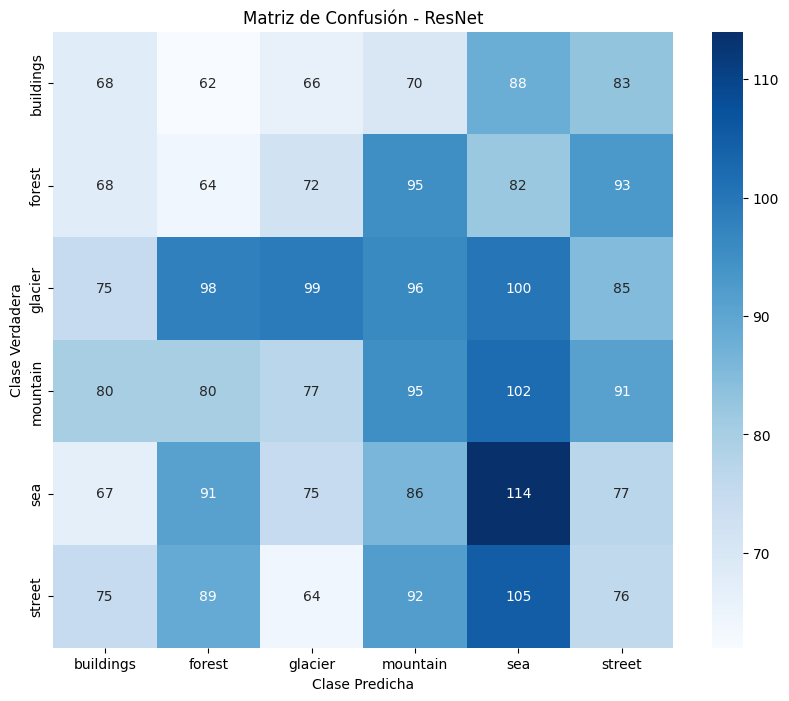


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.16      0.16      0.16       437
      forest       0.13      0.14      0.13       474
     glacier       0.22      0.18      0.20       553
    mountain       0.18      0.18      0.18       525
         sea       0.19      0.22      0.21       510
      street       0.15      0.15      0.15       501

    accuracy                           0.17      3000
   macro avg       0.17      0.17      0.17      3000
weighted avg       0.17      0.17      0.17      3000



In [ ]:
# Predicciones sobre el conjunto de validación
y_pred_probs = model_transfer.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - ResNet')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción

preds = model_transfer.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))
    class_index = predicted_labels[i]
    class_label = class_names[class_index]

    top2_indices = np.argsort(preds[i])[::-1][:2]

    label1 = f"{class_names[top2_indices[0]]}: {preds[i][top2_indices[0]]:.2f}"
    label2 = f"{class_names[top2_indices[1]]}: {preds[i][top2_indices[1]]:.2f}"

    confidence = preds[i][class_index] * 100  # Calculamos dentro del loop
    plt.title(f"Pred: {class_label}", fontsize=12)
    plt.text(0, 170, f"{label1}\n{label2}", fontsize=10, color='black')
    plt.axis("off")
plt.tight_layout()
plt.show()

## Modelo Residual

Nuestro modelo residual utilizará bloques identidad que siguen la siguiente arquitectura

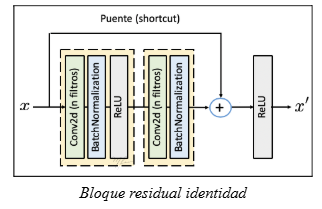

### Definición del modelo

In [ ]:
# Bloque residual identidad

def identity_block(x, filters):
    shortcut = x  # input is used directly as shortcut

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [ ]:
def res_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)

    # Data augmentation
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = ReLU()(x)

    x = identity_block(x, 32)
    x = identity_block(x, 32)
    x = identity_block(x, 32)

    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

### Compilación

In [ ]:
model_resnet = res_net((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Entrenamiento

In [ ]:
EPOCHS = 20

history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc])

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 119s 260ms/step - accuracy: 0.5313 - loss: 1.1859 - val_accuracy: 0.6343 - val_loss: 0.9124
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 143s 261ms/step - accuracy: 0.6832 - loss: 0.8165 - val_accuracy: 0.6480 - val_loss: 0.8603
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 141s 259ms/step - accuracy: 0.7100 - loss: 0.7407 - val_accuracy: 0.5590 - val_loss: 1.0652
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 113s 258ms/step - accuracy: 0.7315 - loss: 0.7019 - val_accuracy: 0.6850 - val_loss: 0.8074
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 113s 258ms/step - accuracy: 0.7546 - loss: 0.6462 - val_accuracy: 0.7530 - val_loss: 0.6555
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 258ms/step - accuracy: 0.7609 - loss: 0.6239 - val_accuracy: 0.4133 - val_loss: 1.5497
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 113s 258ms/step - accuracy: 0.7813 - loss: 0.5961 - val_accuracy: 0.6707 - val_loss: 0.8252
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 113s 257ms/step - accuracy: 0.7906 -

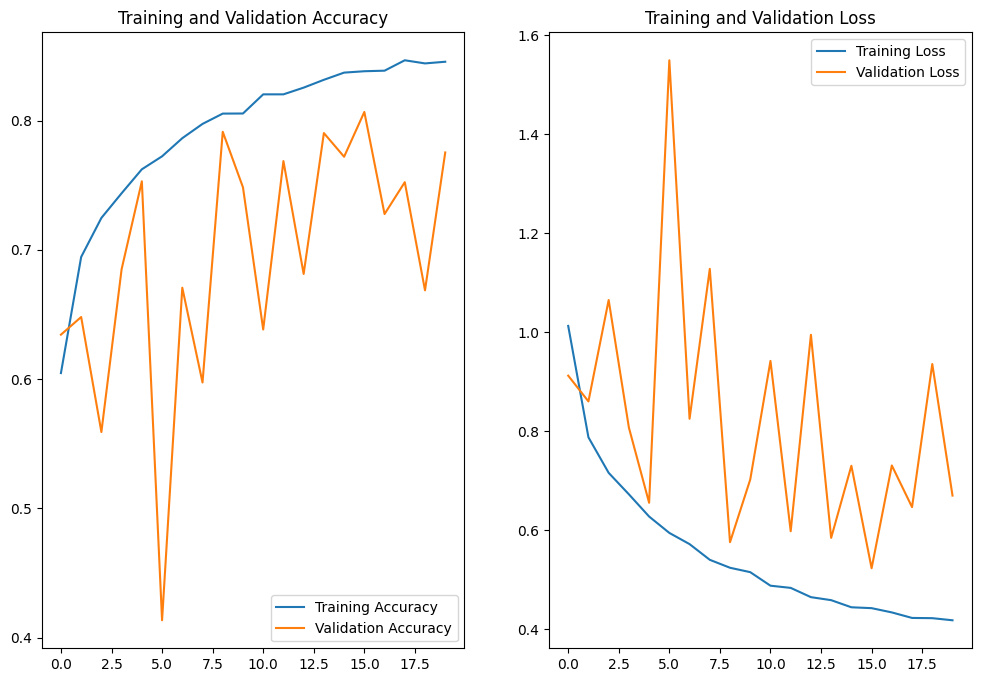

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predicción y matriz de confusión

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step


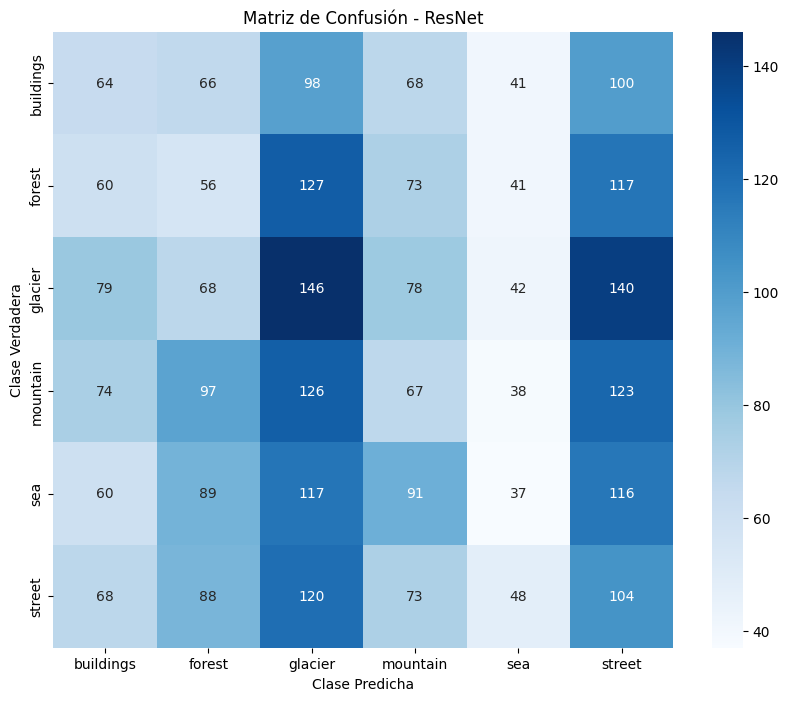


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.16      0.15      0.15       437
      forest       0.12      0.12      0.12       474
     glacier       0.20      0.26      0.23       553
    mountain       0.15      0.13      0.14       525
         sea       0.15      0.07      0.10       510
      street       0.15      0.21      0.17       501

    accuracy                           0.16      3000
   macro avg       0.15      0.16      0.15      3000
weighted avg       0.16      0.16      0.15      3000



In [ ]:
# Predicciones sobre el conjunto de validación
y_pred_probs = model_resnet.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - ResNet')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

Solo un 7% de las fotos de oceano se predijeron correctamente.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


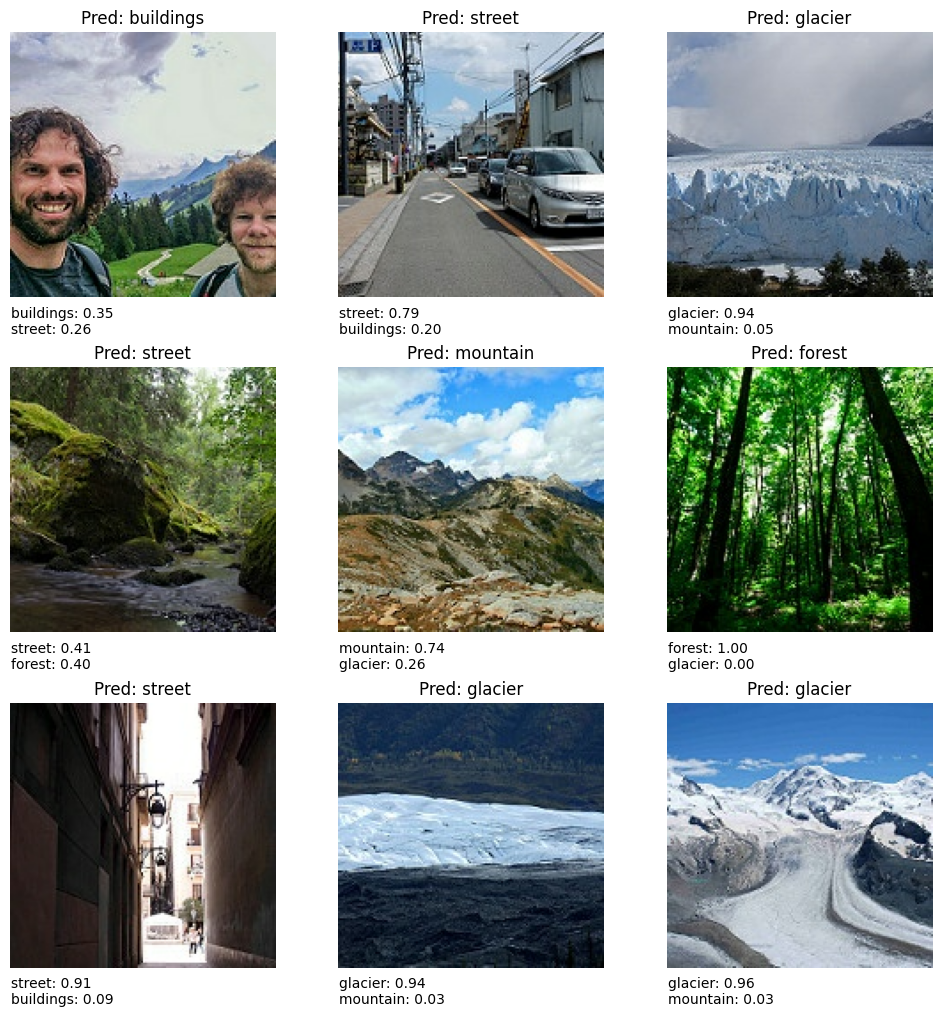

In [ ]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción
preds = model_resnet.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))
    class_index = predicted_labels[i]
    class_label = class_names[class_index]

    top2_indices = np.argsort(preds[i])[::-1][:2]

    label1 = f"{class_names[top2_indices[0]]}: {preds[i][top2_indices[0]]:.2f}"
    label2 = f"{class_names[top2_indices[1]]}: {preds[i][top2_indices[1]]:.2f}"

    confidence = preds[i][class_index] * 100  # Calculamos dentro del loop
    plt.title(f"Pred: {class_label}", fontsize=12)
    plt.text(0, 170, f"{label1}\n{label2}", fontsize=10, color='black')
    plt.axis("off")
plt.tight_layout()
plt.show()